# MPA Model Scratch Sheet

This notebook shows basic use of the MPA model as I've got it working so far.  The fish population and spillover dynamics follow the definitions in this paper.  The fisher dynamics are still a bit of a work in progress...they catch fish following a Type-II functional response, and adjust their preferred MPA size up or down depending on whether they caught more fish this timestep than last timestep.  That last part probably needs more thought and attention, but it's producing some crude results at this point that are at least worth discussing.



In [62]:
using Plots
include("mpa_model.jl")
m = MpaModel;

Definitions of model parameters.  With a little thought it may be possible to make some of these dimensionless, but I've left them concrete for now. 

In [63]:
# Fishing ground parameters
K = 1 # carrying capacity, ton fish km^-2
r = 0.2 # Intrinsic growth rate of fish populations
A = 100 # Area of fishing ground, km^2
α0 = 0.0 # Proportion of fishing ground in MPA at start
α100 = 0.3 # Proportion of fishing ground in MPA after 100 timesteps
μ = 0.1 # reserve spillover parameter

# Fisher parameters
a = .5 # Search rate, km^2 d^-1
Th = 1 # Handling time, boat d (ton fish)^-1
αpref = 0.0 # The fishers' preferred reserve fraction at beginning
Δα = 0.01 # How fast the fishers adjust their preferred reserve size
Nfishers = 20; # Number of fishers




20

I define a function that sets up and runs a simulation.  After running for 100 timesteps, to let things come to equilibrium, I change the fraction of the fishing ground which is protected.  I also define a convenience plotting function do display the results.

In [64]:
function run_simulation(params, nsim)
    K, r, A, α0, α100, μ, a, Th, αpref, Δα, Nfishers = params
    # Biomass in reserve and open areas. Both start at carrying capacity
    Nreserve = A * α * K
    Nopen = A * (1-α) * K

    # Instantiate an array of OpinionatedFishers
    fishers = [m.OpinionatedFisher(a, Th, αpref, Δα) for i in 1:Nfishers]
    # Instantiate a FishingGround
    ground = m.FishingGround(K, r, A, α, μ, Nreserve, Nopen)

    NNres = zeros(nsim)
    NNopen = zeros(nsim)
    landings = zeros(nsim)
    αα_avg = zeros(nsim)

    for t in 1:nsim
        NNres[t] = ground.Nreserve
        NNopen[t] = ground.Nopen
        landings[t] = m.update!(ground, fishers)
        if t == 100
            m.set_protected!(ground, α100)
            αα_avg[t] = α100
        end
        if t > 100
            αα_avg[t] = m.α_consensus(fishers)
            m.set_protected!(ground, αα_avg[t])
        end
    end
    return (NNopen, NNres, landings, αα_avg)
end

function plot_results(NNopen, NNres, landings, αα_avg, burnin=1)
    p1 = plot(NNopen[burnin:end], label="Open biomass");
    plot!(p1, NNres[burnin:end], label="MPA biomass");
    plot!(p1, landings[burnin:end], label="Landings");
    p2 = plot(landings[burnin:end], label="Landings", linecolor=:green);
    p3 = plot(αα_avg[burnin:end], label="MPA fraction", linecolor=:black);
    p = plot(p1, p2, p3, layout=(3,1))
    return p
end
αα

UndefVarError: UndefVarError: αα not defined

Packing all the parameters into a named tuple and running the simulation:

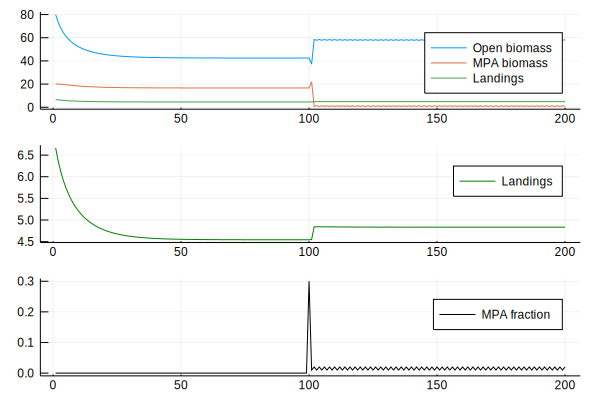

In [65]:
params = (K=K, r=r, A=A, α0=α0, α100=α100, μ=μ, 
    a=a, Th=Th, αpref=αpref, Δα=Δα, Nfishers=Nfishers)
nsim = 200
res = run_simulation(params, nsim) #NNopen, NNres, landings, αα_avg
plot_results(res...)

Plotting without the inital transient period so we can see the changes a little better:

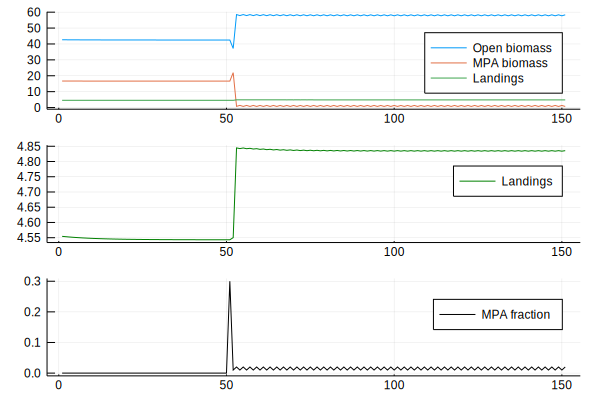

In [66]:
plot_results(res..., 50)

Next, change the parameter `Th` and re-run the simulation. `Th` is the "handling time" in the Type-II functional response, which ultimately determines how fast the fishers can catch fish.  The maximum catch rate per boat is `1/Th`, so making it smaller increases the actual maximum catch rate.

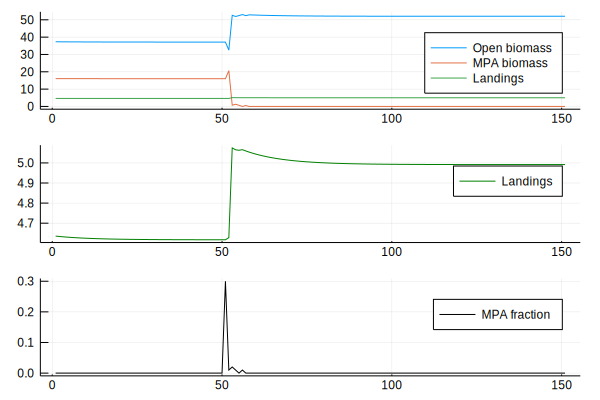

In [67]:
params = (K=K, r=r, A=A, α0=α0, α100=α100, μ=μ, 
    a=a, Th=0.5, αpref=αpref, Δα=Δα, Nfishers=Nfishers)
res = run_simulation(params, nsim)
plot_results(res..., 50)

In this case, landings initially increase following establishment of the MPA, but decline in the next timestep.  This decline leads the fishers to "vote" to decrease the MPA size, leading to the vicious feedback cycle where they eliminate it after a few timesteps.